# 1. Initial Setup & Data Preparation

**Purpose:**
1.  **Mount Google Drive**: To access the dataset stored in your Drive.
2.  **Data Splitting**: We automatically split the raw `train` folder into `train` (70%), `validation` (20%), and `test` (10%) sets. This ensures a robust evaluation pipeline with unseen data.


In [ ]:
# ==========================================
# 1. DATA PREPARATION SCRIPT
# ==========================================
# This script organizes your dataset for training.
# It moves images from the 'train' folder to create
# 'validation' and 'test' sets based on the 70/20/10 split.
#
import os
import shutil
import random
import math
import time
from google.colab import drive

print("--- (Step 0) Mounting Google Drive ---")
drive.mount('/content/drive')
time.sleep(2) # Give it a moment to mount
print("Google Drive mounted successfully.")

print("\n--- 🤖 Starting Data Split Script ---")
print("WARNING: This script will MOVE files from your 'train' folder to 'validation' and 'test'.")
print("This is a one-time operation. Please ensure you have a backup if needed.")

# --- 1. Define Paths (Based on your directory) ---
BASE_DIR = '/content/drive/MyDrive/FYP'
# This is your folder with 100% of the data
SOURCE_DIR = os.path.join(BASE_DIR, 'train')
# These are your empty destination folders
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# --- 2. Define Split Ratios (70/20/10) ---
VALIDATION_SPLIT = 0.20
TEST_SPLIT = 0.10
# 70% will be left in the SOURCE_DIR

print(f"Source of all images: {SOURCE_DIR}")
print(f"Destination for validation set: {VALIDATION_DIR}")
print(f"Destination for test set: {TEST_DIR}")

# --- 3. Run the Split ---
if not os.path.exists(SOURCE_DIR):
    print(f"\nERROR: The source directory was not found: {SOURCE_DIR}")
else:
    all_class_names = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
    print(f"Found {len(all_class_names)} classes: {all_class_names}")

    if not all_class_names:
        print(f"\nERROR: The directory '{SOURCE_DIR}' is empty or contains no class sub-folders.")
        print("This script expects 100% of your data to be in this 'train' folder before running.")
    else:
        for class_name in all_class_names:
            print(f"\nProcessing class: {class_name}")

            # Define source and destination paths for this class
            source_class_dir = os.path.join(SOURCE_DIR, class_name)
            validation_class_dir = os.path.join(VALIDATION_DIR, class_name)
            test_class_dir = os.path.join(TEST_DIR, class_name)

            # Create the destination folders
            os.makedirs(validation_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Get list of all images
            all_files = [f for f in os.listdir(source_class_dir) if os.path.isfile(os.path.join(source_class_dir, f))]

            if not all_files:
                print(f"  WARNING: No files found for class {class_name}. Skipping.")
                continue

            total_files = len(all_files)
            print(f"  Found {total_files} total images.")

            random.shuffle(all_files)

            # Calculate the number of files for each set
            num_test = math.ceil(total_files * TEST_SPLIT)
            num_validation = math.ceil(total_files * VALIDATION_SPLIT)
            num_train = total_files - num_test - num_validation

            # Get the lists of files to move
            files_to_move_test = all_files[:num_test]
            files_to_move_validation = all_files[num_test : num_test + num_validation]

            # Move the test files
            for f in files_to_move_test:
                shutil.move(
                    os.path.join(source_class_dir, f),
                    os.path.join(test_class_dir, f)
                )

            # Move the validation files
            for f in files_to_move_validation:
                shutil.move(
                    os.path.join(source_class_dir, f),
                    os.path.join(validation_class_dir, f)
                )

            print(f"  Moved {len(files_to_move_test)} files to 'test' ({TEST_SPLIT*100}%)")
            print(f"  Moved {len(files_to_move_validation)} files to 'validation' ({VALIDATION_SPLIT*100}%)")
            print(f"  Left {num_train} files in 'train' ({(num_train/total_files)*100:.0f}%)")

print("\n--- ✅ Data Split Complete ---")
print("Your 'train' folder now contains 70% of the data.")
print("Your 'validation' and 'test' folders now contain 20% and 10%, respectively.")

--- (Step 0) Mounting Google Drive ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.

--- 🤖 Starting Data Split Script ---
This is a one-time operation. Please ensure you have a backup if needed.
Source of all images: /content/drive/MyDrive/FYP/train
Destination for validation set: /content/drive/MyDrive/FYP/validation
Destination for test set: /content/drive/MyDrive/FYP/test
Found 7 classes: ['kuih_talam', 'kuih_ubi_kayu', 'onde_onde', 'kuih_lapis', 'kuih_seri_muka', 'kuih_ketayap', 'kuih_kaswi_pandan']

Processing class: kuih_talam
  Found 966 total images.
  Moved 97 files to 'test' (10.0%)
  Moved 194 files to 'validation' (20.0%)
  Left 675 files in 'train' (70%)

Processing class: kuih_ubi_kayu
  Found 848 total images.
  Moved 85 files to 'test' (10.0%)
  Moved 170 files to 'validation' (20.0%)
  Left 593 files in 'train' (70%)

Processing class: onde_onde
  Foun

# 2. Model Development & Evaluation

**Overview:**
In this section, we will:
1.  **Import Libraries**: Load TensorFlow, Keras, and helper modules.
2.  **Define Models**: Compare a custom **AlexNet** (trained from scratch) against Pre-trained Models (**ResNet50, MobileNetV2, EfficientNetB0**).
3.  **Train**: Run training loops and save history graphs.
4.  **Evaluate**: Test all models on the unseen 10% `test` set and generate classification reports.


Mounted at /content/drive
Google Drive Mounted.
Training data: /content/drive/MyDrive/FYP/train
Models will be saved to: /content/drive/MyDrive/FYP/MyModels
History graphs will be saved to: /content/drive/MyDrive/FYP/MyModels/graphs
Found 7 classes: ['kuih_kaswi_pandan', 'kuih_ketayap', 'kuih_lapis', 'kuih_seri_muka', 'kuih_talam', 'kuih_ubi_kayu', 'onde_onde']

--- 🧠 PHASE 1: MODEL DEVELOPMENT ---

--- Training AlexNet (1 of 4) ---
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 4343s 28s/step - accuracy: 0.4266 - loss: 1.7076 - val_accuracy: 0.3417 - val_loss: 1.8267
Epoch 2/25
  1/157 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.7188 - loss: 0.8843

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.7188 - loss: 0.8843 - val_accuracy: 0.3507 - val_loss: 1.8062
Epoch 3/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 107s 681ms/step - accuracy: 0.6012 - loss: 1.0935 - val_accuracy: 0.3111 - val_loss: 1.8517
Epoch 4/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5938 - loss: 0.9699 - val_accuracy: 0.3160 - val_loss: 1.8467
Epoch 5/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 105s 672ms/step - accuracy: 0.6415 - loss: 0.9868 - val_accuracy: 0.6000 - val_loss: 1.0896
Epoch 6/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8125 - loss: 0.6753 - val_accuracy: 0.6097 - val_loss: 1.0459
Epoch 7/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 105s 669ms/step - accuracy: 0.6697 - loss: 0.8945 - val_accuracy: 0.7368 - val_loss: 0.7536
Epoch 8/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.6875 - loss: 0.8632 - val_accuracy: 0.7229 - val_loss: 0.7529
Epoch 9/25
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 904ms/step - accuracy: 0.6908 - loss: 0.8446 - val

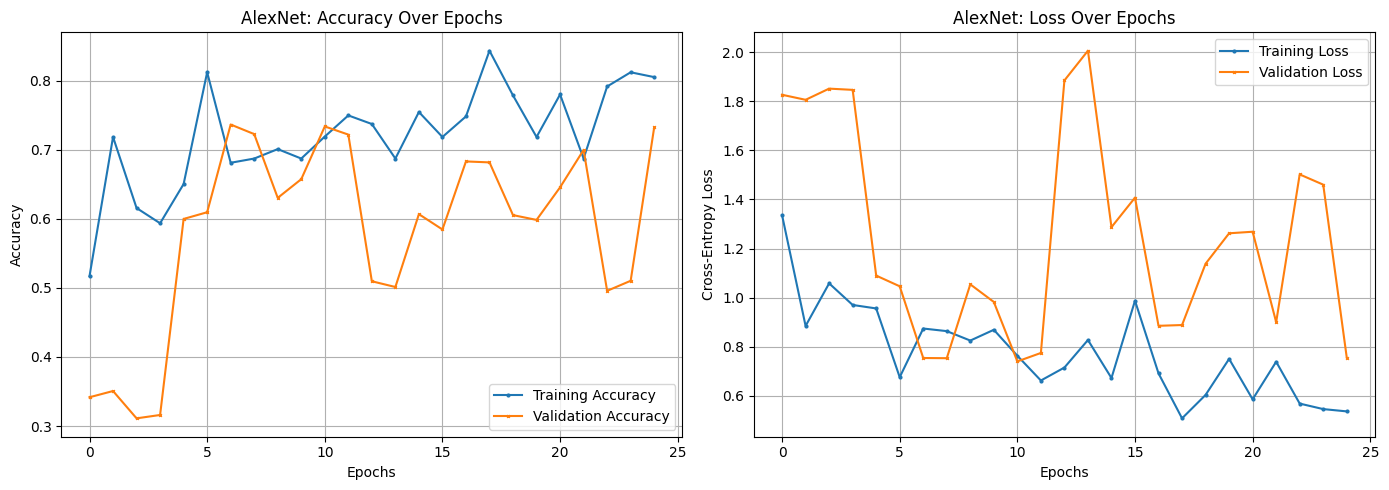

✅ History graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_AlexNet.png

--- Training ResNet50 (2 of 4) ---
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 134s 758ms/step - accuracy: 0.6795 - loss: 1.1592 - val_accuracy: 0.8639 - val_loss: 0.4046
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7500 - loss: 0.5679 - val_accuracy: 0.8479 - val_loss: 0.4443
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 110s 697ms/step - accuracy: 0.8771 - loss: 0.3308 - val_accuracy: 0.8986 - val_loss: 0.3010
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9062 - loss: 0.1124 - val_accuracy: 0.8938 - val_loss: 0.2979
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 695ms/step - accuracy: 0.9051 - loss: 0.2428 - val_accuracy: 0.8681 - val_loss: 0.3641
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.7812 - loss: 0.4

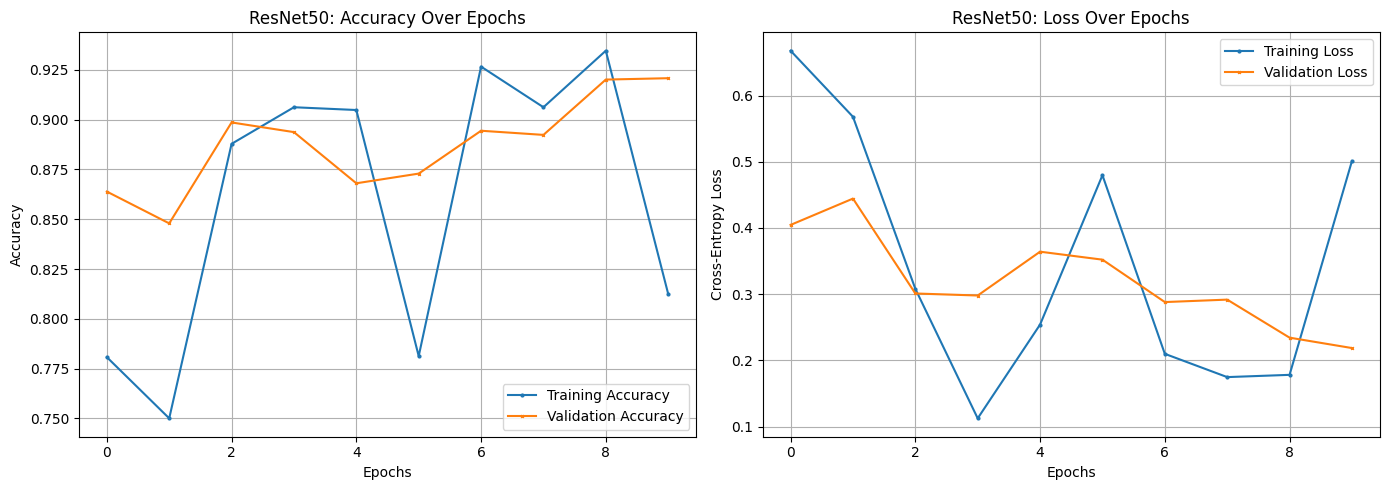

✅ History graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_ResNet50.png

--- Training MobileNetV2 (3 of 4) ---
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 788ms/step - accuracy: 0.6504 - loss: 1.0896 - val_accuracy: 0.8583 - val_loss: 0.4100
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.9062 - loss: 0.3023 - val_accuracy: 0.8514 - val_loss: 0.4276
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 905ms/step - accuracy: 0.8560 - loss: 0.4107 - val_accuracy: 0.8674 - val_loss: 0.3412
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.9062 - loss: 0.2511 - val_accuracy: 0.8646 - val_loss: 0.3502
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 104s 660ms/step - accuracy: 0.8642 - loss: 0.3724 - val_accuracy: 0.8625 - val_loss: 0.3850
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8125 - loss: 0

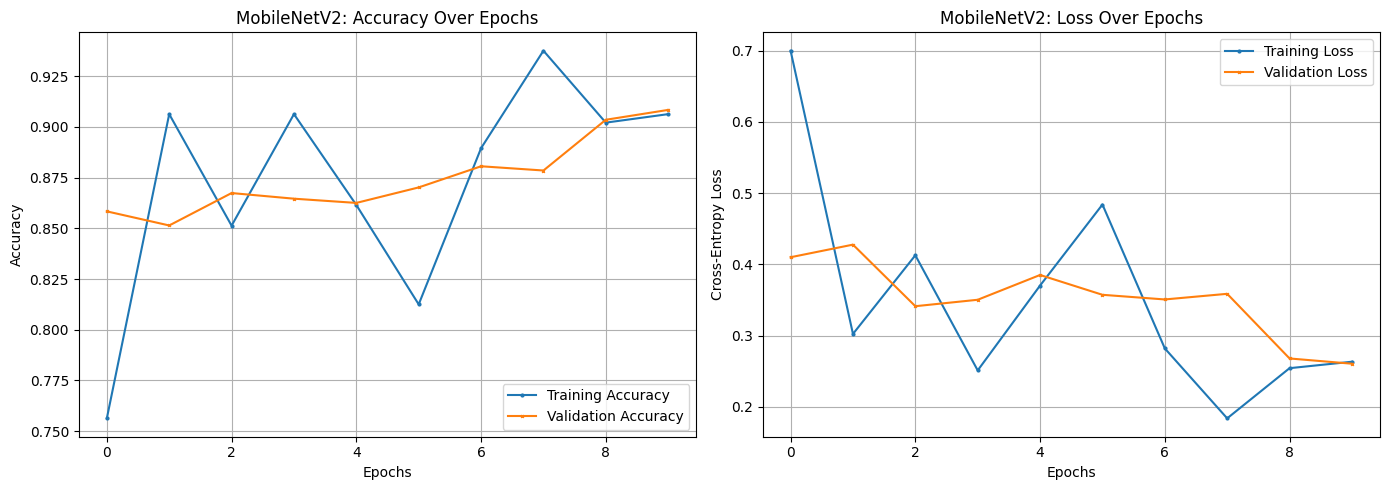

✅ History graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_MobileNetV2.png

--- Training EfficientNetB0 (4 of 4) ---
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 147s 785ms/step - accuracy: 0.7570 - loss: 0.6562 - val_accuracy: 0.8903 - val_loss: 0.2857
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8438 - loss: 0.3027 - val_accuracy: 0.8910 - val_loss: 0.2890
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 906ms/step - accuracy: 0.9072 - loss: 0.2689 - val_accuracy: 0.9139 - val_loss: 0.2225
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.9688 - loss: 0.1034 - val_accuracy: 0.9187 - val_loss: 0.2138
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 104s 660ms/step - accuracy: 0.9334 - loss: 0.1936 - val_accuracy: 0.9347 - val_loss: 0.1952
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9688 -

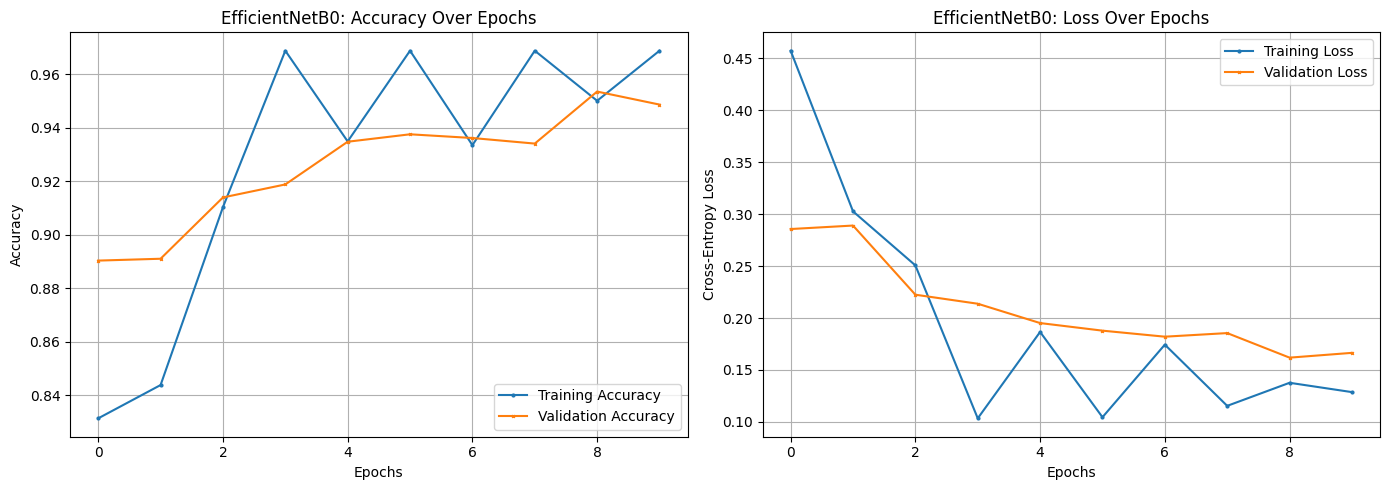

✅ History graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_EfficientNetB0.png

--- ✅ PHASE 1 COMPLETE: All models trained and history plots saved. ---

--- 📊 PHASE 2: EVALUATION & TESTING ---
Found 724 images belonging to 7 classes.

--- Evaluating: AlexNet ---


Found 724 images belonging to 7 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 453s 21s/step
                   precision    recall  f1-score   support

kuih_kaswi_pandan       0.81      0.55      0.66       101
     kuih_ketayap       0.66      0.80      0.73       101
       kuih_lapis       0.98      0.80      0.88       153
   kuih_seri_muka       0.54      0.71      0.61        80
       kuih_talam       0.90      0.44      0.59        97
    kuih_ubi_kayu       0.72      0.95      0.82        85
        onde_onde       0.65      0.86      0.74       107

         accuracy                           0.74       724
        macro avg       0.75      0.73      0.72       724
     weighted avg       0.77      0.74      0.73       724


--- Evaluating: ResNet50 ---


Found 724 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 556ms/step
                   precision    recall  f1-score   support

kuih_kaswi_pandan       0.86      0.91      0.88       101
     kuih_ketayap       0.91      0.98      0.94       101
       kuih_lapis       0.96      0.93      0.94       153
   kuih_seri_muka       0.97      0.74      0.84        80
       kuih_talam       0.87      0.92      0.89        97
    kuih_ubi_kayu       0.93      0.99      0.96        85
        onde_onde       0.92      0.92      0.92       107

         accuracy                           0.92       724
        macro avg       0.92      0.91      0.91       724
     weighted avg       0.92      0.92      0.91       724


--- Evaluating: MobileNetV2 ---


Found 724 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 796ms/step
                   precision    recall  f1-score   support

kuih_kaswi_pandan       0.96      0.88      0.92       101
     kuih_ketayap       0.88      0.99      0.93       101
       kuih_lapis       0.96      0.95      0.95       153
   kuih_seri_muka       0.89      0.79      0.83        80
       kuih_talam       0.83      0.92      0.87        97
    kuih_ubi_kayu       0.93      0.91      0.92        85
        onde_onde       0.93      0.92      0.92       107

         accuracy                           0.91       724
        macro avg       0.91      0.91      0.91       724
     weighted avg       0.92      0.91      0.91       724


--- Evaluating: EfficientNetB0 ---


Found 724 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 706ms/step
                   precision    recall  f1-score   support

kuih_kaswi_pandan       0.89      0.90      0.90       101
     kuih_ketayap       0.97      0.96      0.97       101
       kuih_lapis       0.97      0.96      0.97       153
   kuih_seri_muka       0.89      0.90      0.89        80
       kuih_talam       0.93      0.89      0.91        97
    kuih_ubi_kayu       0.95      0.99      0.97        85
        onde_onde       0.93      0.95      0.94       107

         accuracy                           0.94       724
        macro avg       0.93      0.94      0.93       724
     weighted avg       0.94      0.94      0.94       724


--- 🏆 FINAL MODEL COMPARISON (Weighted Avg on TEST Set) ---
Model            | Accuracy   | Precision  | Recall     | F1-Score  
-----------------------------------------------------------------
AlexNet          | 0.7362     | 0.7739     | 0.7362     | 0.7332    
ResNet50         | 0.9157     | 0.9181   

In [ ]:
# ==========================================
# 2. MODEL TRAINING & EVALUATION SCRIPT
# ==========================================
# This block handles the entire ML pipeline:
# - Imports necessary libraries (TensorFlow/Keras)
# - Defines training constants (Batch Size, Epochs)
# - Trains AlexNet from scratch
# - Fine-tunes Transfer Learning models
# - Evaluates performance on the Test Set
#
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Input, Flatten,
    Conv2D, MaxPooling2D, BatchNormalization, Dropout
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Import specific models and their preprocessing functions
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import os
import time

# --- 1. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
print("Google Drive Mounted.")

# --- 2. Define Project Paths ---
BASE_DIR = '/content/drive/MyDrive/FYP'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DIR, 'test')
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'MyModels')
GRAPH_DIR = os.path.join(MODEL_SAVE_DIR, 'graphs') # New directory for history plots

os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(GRAPH_DIR, exist_ok=True)
print(f"Training data: {TRAIN_DIR}")
print(f"Models will be saved to: {MODEL_SAVE_DIR}")
print(f"History graphs will be saved to: {GRAPH_DIR}")

# --- 3. Helper Function for History Plotting ---
def save_history_plot(history, model_name):
    """Generates and saves Training vs Validation Accuracy and Loss plots."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o', markersize=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x', markersize=2)
    plt.title(f'{model_name}: Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o', markersize=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x', markersize=2)
    plt.title(f'{model_name}: Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plot_path = os.path.join(GRAPH_DIR, f'history_{model_name}.png')
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ History graph saved to: {plot_path}")

# --- 4. Define Model Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS_TRANSFER = 10
EPOCHS_SCRATCH = 25

# --- 5. Get Class Information ---
class_names = sorted(os.listdir(TRAIN_DIR))
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes: {class_names}\n")

#####################################################################
# PHASE 1: MODEL DEVELOPMENT
#####################################################################
print("="*60)
print("--- 🧠 PHASE 1: MODEL DEVELOPMENT ---")
print("="*60)

# --- 1.1 Training AlexNet (From Scratch) ---
print(f"\n--- Training AlexNet (1 of 4) ---")
alexnet_train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=40, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode='nearest'
)
alexnet_validation_datagen = ImageDataGenerator(rescale=1./255)

train_gen_alexnet = alexnet_train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_gen_alexnet = alexnet_validation_datagen.flow_from_directory(VALIDATION_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

alexnet_model = Sequential([
    Input(shape=IMG_SIZE + (3,)),
    Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same'),
    BatchNormalization(), MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(256, (5, 5), activation='relu', padding='same'),
    BatchNormalization(), MaxPooling2D((3, 3), strides=(2, 2)),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'), Dropout(0.5),
    Dense(4096, activation='relu'), Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

alexnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train and capture history
history_alex = alexnet_model.fit(
    train_gen_alexnet, epochs=EPOCHS_SCRATCH, validation_data=val_gen_alexnet,
    steps_per_epoch=train_gen_alexnet.n // BATCH_SIZE,
    validation_steps=val_gen_alexnet.n // BATCH_SIZE
)

save_history_plot(history_alex, "AlexNet")
alexnet_model.save(os.path.join(MODEL_SAVE_DIR, 'AlexNet_v1.h5'))

# --- 1.2 Training Transfer Learning Models ---
transfer_models = {
    'ResNet50': (ResNet50, resnet_preprocess),
    'MobileNetV2': (MobileNetV2, mobilenet_preprocess),
    'EfficientNetB0': (EfficientNetB0, efficientnet_preprocess)
}

model_count = 2
for model_name, (BaseModel, preprocess_function) in transfer_models.items():
    print(f"\n--- Training {model_name} ({model_count} of 4) ---")

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_function, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

    train_gen = train_datagen.flow_from_directory(TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
    val_gen = val_datagen.flow_from_directory(VALIDATION_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

    base_model = BaseModel(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Train and capture history
    history = model.fit(
        train_gen, epochs=EPOCHS_TRANSFER, validation_data=val_gen,
        steps_per_epoch=train_gen.n // BATCH_SIZE,
        validation_steps=val_gen.n // BATCH_SIZE
    )

    save_history_plot(history, model_name)
    model.save(os.path.join(MODEL_SAVE_DIR, f'{model_name}_v1.h5'))
    model_count += 1

print("\n--- ✅ PHASE 1 COMPLETE: All models trained and history plots saved. ---")

#####################################################################
# PHASE 2: EVALUATION & TESTING
#####################################################################
print("\n" + "="*60)
print("--- 📊 PHASE 2: EVALUATION & TESTING ---")
print("="*60)

# --- 2.1 Get True Labels ---
test_gen_labels = ImageDataGenerator(rescale=1./255).flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
true_labels = test_gen_labels.classes

# --- 2.2 Evaluation Config ---
model_eval_config = {
    'AlexNet': {'path': os.path.join(MODEL_SAVE_DIR, 'AlexNet_v1.h5'), 'gen': ImageDataGenerator(rescale=1./255)},
    'ResNet50': {'path': os.path.join(MODEL_SAVE_DIR, 'ResNet50_v1.h5'), 'gen': ImageDataGenerator(preprocessing_function=resnet_preprocess)},
    'MobileNetV2': {'path': os.path.join(MODEL_SAVE_DIR, 'MobileNetV2_v1.h5'), 'gen': ImageDataGenerator(preprocessing_function=mobilenet_preprocess)},
    'EfficientNetB0': {'path': os.path.join(MODEL_SAVE_DIR, 'EfficientNetB0_v1.h5'), 'gen': ImageDataGenerator(preprocessing_function=efficientnet_preprocess)}
}

model_performance_report = {}

for model_name, config in model_eval_config.items():
    print(f"\n--- Evaluating: {model_name} ---")
    eval_model = load_model(config['path'])
    test_gen = config['gen'].flow_from_directory(TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

    predictions = eval_model.predict(test_gen)
    y_pred = np.argmax(predictions, axis=1)

    report = classification_report(true_labels, y_pred, target_names=class_names, output_dict=True)
    model_performance_report[model_name] = report
    print(classification_report(true_labels, y_pred, target_names=class_names))

# --- 2.4 Final Comparison Summary ---
print("\n" + "="*65)
print("--- 🏆 FINAL MODEL COMPARISON (Weighted Avg on TEST Set) ---")
print("="*65)
print(f"{'Model':<16} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 65)
for name, rep in model_performance_report.items():
    w = rep['weighted avg']
    print(f"{name:<16} | {rep['accuracy']:<10.4f} | {w['precision']:<10.4f} | {w['recall']:<10.4f} | {w['f1-score']:<10.4f}")
print("="*65)

# Fine tuning

Mounted at /content/drive
--- 🧠 Starting Fine-Tuning for 3 Models (Saving as .keras) ---

--- Fine-Tuning Model: ResNet50 ---


Total base layers: 175
Froze: 140 | Training: 35
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Starting fine-tuning for 15 epochs...
Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 143s 779ms/step - accuracy: 0.9158 - loss: 0.2496 - val_accuracy: 0.9312 - val_loss: 0.1875
Epoch 2/15
  1/157 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.9062 - loss: 0.2729

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.9062 - loss: 0.2729 - val_accuracy: 0.9333 - val_loss: 0.1853
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 111s 705ms/step - accuracy: 0.9574 - loss: 0.1308 - val_accuracy: 0.9403 - val_loss: 0.1574
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 130ms/step - accuracy: 0.8750 - loss: 0.2829 - val_accuracy: 0.9410 - val_loss: 0.1572
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 110s 698ms/step - accuracy: 0.9642 - loss: 0.1112 - val_accuracy: 0.9465 - val_loss: 0.1503
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.9688 - loss: 0.0691 - val_accuracy: 0.9465 - val_loss: 0.1488
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 108s 691ms/step - accuracy: 0.9726 - loss: 0.0879 - val_accuracy: 0.9486 - val_loss: 0.1507
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.9688 - loss: 0.0666 - val_accuracy: 0.9493 - val_loss: 0.1489
Epoch 9/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 696ms/step - accuracy: 0.9810 - loss: 0.0686 - va

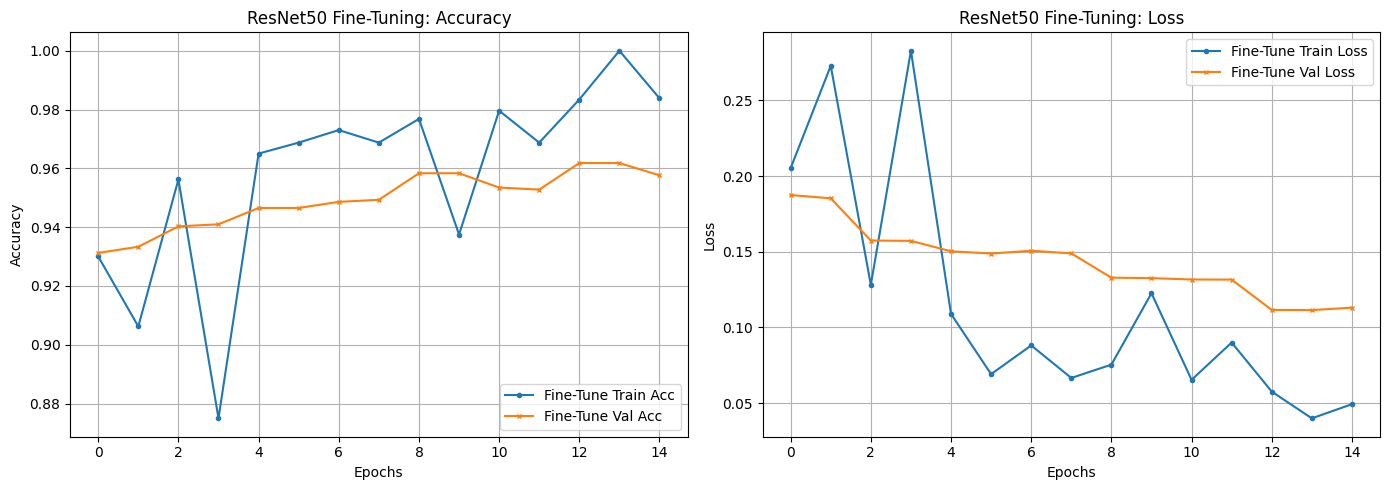

✅ Fine-Tuning history graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_ResNet50_FT_Progress.png
--- ✅ Fine-Tuning Complete: ResNet50 ---

--- Fine-Tuning Model: MobileNetV2 ---


Total base layers: 154
Froze: 123 | Training: 31
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.

Starting fine-tuning for 15 epochs...
Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 134s 738ms/step - accuracy: 0.8176 - loss: 0.5066 - val_accuracy: 0.8938 - val_loss: 0.2992
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.9062 - loss: 0.2550 - val_accuracy: 0.8951 - val_loss: 0.3001
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 104s 663ms/step - accuracy: 0.8841 - loss: 0.3331 - val_accuracy: 0.8951 - val_loss: 0.3093
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.8750 - loss: 0.3753 - val_accuracy: 0.8965 - val_loss: 0.3060
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 908ms/step - accuracy: 0.8869 - loss: 0.3116 - val_accuracy: 0.9007 - val_loss: 0.2918
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8125 - loss: 0.3596 - val_accuracy: 0.9014 - val_loss: 0.2906
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 15

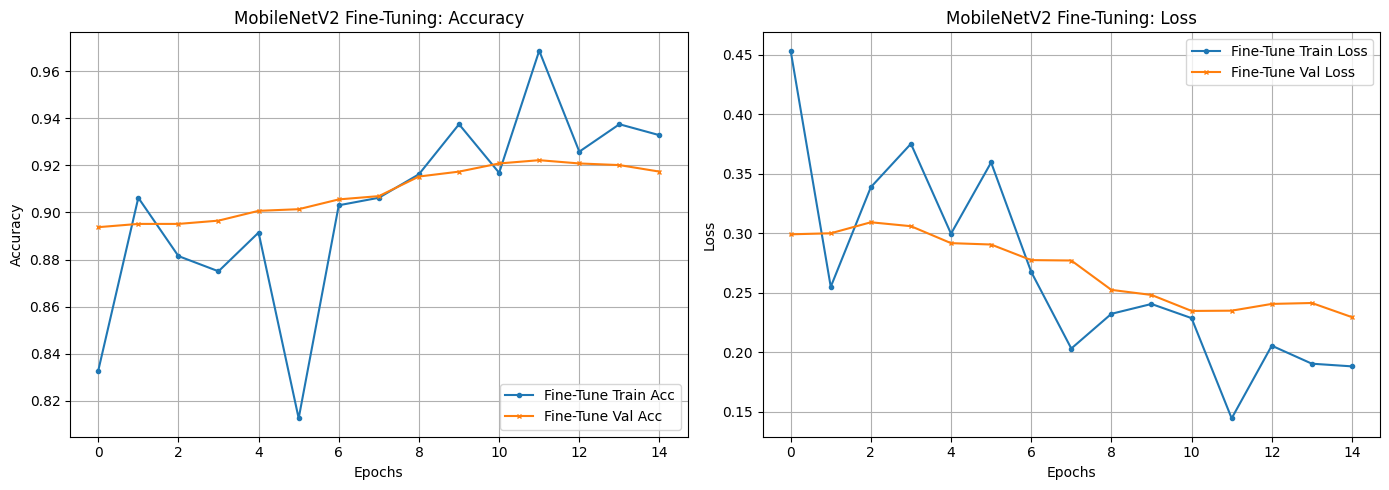

✅ Fine-Tuning history graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_MobileNetV2_FT_Progress.png
--- ✅ Fine-Tuning Complete: MobileNetV2 ---

--- Fine-Tuning Model: EfficientNetB0 ---


Total base layers: 11
Froze: 8 | Training: 3
Found 5035 images belonging to 7 classes.
Found 1444 images belonging to 7 classes.

Starting fine-tuning for 15 epochs...
Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 154s 799ms/step - accuracy: 0.9260 - loss: 0.1987 - val_accuracy: 0.9340 - val_loss: 0.1956
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 1.0000 - loss: 0.0495 - val_accuracy: 0.9347 - val_loss: 0.1964
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 104s 663ms/step - accuracy: 0.9368 - loss: 0.1701 - val_accuracy: 0.9326 - val_loss: 0.2206
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9375 - loss: 0.1174 - val_accuracy: 0.9326 - val_loss: 0.2206
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 103s 655ms/step - accuracy: 0.9511 - loss: 0.1490 - val_accuracy: 0.9312 - val_loss: 0.2237
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9375 - loss: 0.1865 - val_accuracy: 0.9312 - val_loss: 0.2238
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 9

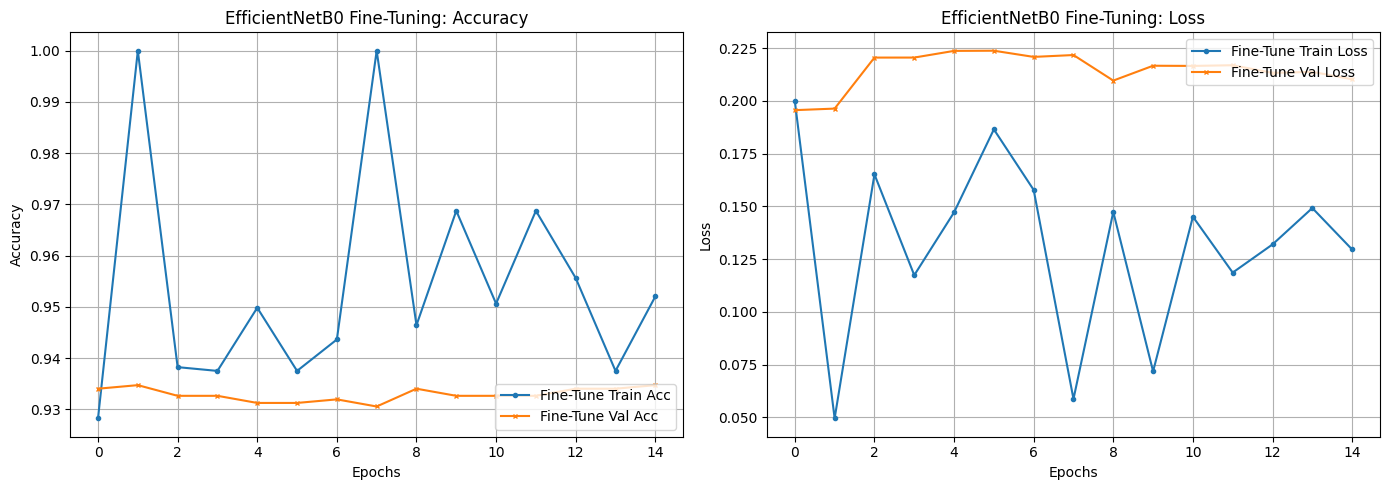

✅ Fine-Tuning history graph saved to: /content/drive/MyDrive/FYP/MyModels/graphs/history_EfficientNetB0_FT_Progress.png
--- ✅ Fine-Tuning Complete: EfficientNetB0 ---

--- ✅ ALL FINE-TUNING FINISHED AND GRAPHS SAVED ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Import all preprocessing functions
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# --- 1. Mount Drive and Set Paths ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = '/content/drive/MyDrive/FYP'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALIDATION_DIR = os.path.join(BASE_DIR, 'validation')
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'MyModels')
GRAPH_DIR = os.path.join(MODEL_SAVE_DIR, 'graphs')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Ensure the graphs directory exists
os.makedirs(GRAPH_DIR, exist_ok=True)

# --- 2. Define Fine-Tuning Parameters ---
FINE_TUNE_EPOCHS = 15
LEARNING_RATE_FT = 0.00001 # 1e-5 (Very low for stability)

# --- 3. Model Configuration ---
model_config = {
    'ResNet50': resnet_preprocess,
    'MobileNetV2': mobilenet_preprocess,
    'EfficientNetB0': efficientnet_preprocess
}

# --- 4. Helper Function for History Plotting ---
def save_finetune_history_plot(history, model_name):
    """Generates and saves Fine-Tuning Training vs Validation plots."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Fine-Tune Train Acc', marker='o', markersize=3)
    plt.plot(epochs_range, val_acc, label='Fine-Tune Val Acc', marker='x', markersize=3)
    plt.title(f'{model_name} Fine-Tuning: Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Fine-Tune Train Loss', marker='o', markersize=3)
    plt.plot(epochs_range, val_loss, label='Fine-Tune Val Loss', marker='x', markersize=3)
    plt.title(f'{model_name} Fine-Tuning: Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plot_path = os.path.join(GRAPH_DIR, f'history_{model_name}_FT_Progress.png')
    plt.savefig(plot_path)
    plt.show()
    print(f"✅ Fine-Tuning history graph saved to: {plot_path}")

print("--- 🧠 Starting Fine-Tuning for 3 Models (Saving as .keras) ---")

# --- 5. Start the Fine-Tuning Loop ---
for model_name, preprocess_function in model_config.items():
    print("\n" + "="*60)
    print(f"--- Fine-Tuning Model: {model_name} ---")
    print("="*60)

    baseline_path = os.path.join(MODEL_SAVE_DIR, f'{model_name}_v1.h5')
    finetuned_path = os.path.join(MODEL_SAVE_DIR, f'{model_name}_v1_ft.keras')

    if not os.path.exists(baseline_path):
        print(f"ERROR: Baseline model {baseline_path} not found. Ensure Phase 1 ran correctly.")
        continue

    # 1. Load the Baseline Model
    model = load_model(baseline_path)

    # 2. Identify and unfreeze top layers
    split_point_found = False
    base_model_layer_count = 0
    for layer in model.layers:
        if isinstance(layer, GlobalAveragePooling2D):
            split_point_found = True
            break
        base_model_layer_count += 1
        layer.trainable = True # Set all to true initially

    if not split_point_found:
        print(f"ERROR: Could not find 'GlobalAveragePooling2D' layer in {model_name}.")
        continue

    # 3. Freeze the bottom 80% to preserve feature extraction
    layers_to_freeze = int(base_model_layer_count * 0.8)
    for i in range(layers_to_freeze):
        model.layers[i].trainable = False

    print(f"Total base layers: {base_model_layer_count}")
    print(f"Froze: {layers_to_freeze} | Training: {base_model_layer_count - layers_to_freeze}")

    # 4. Re-compile with low learning rate
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_FT),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # 5. Data Generators
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_function,
        rotation_range=40, width_shift_range=0.2,
        height_shift_range=0.2, shear_range=0.2,
        zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
    )
    validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_function)

    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR, target_size=IMG_SIZE,
        batch_size=BATCH_SIZE, class_mode='categorical'
    )
    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR, target_size=IMG_SIZE,
        batch_size=BATCH_SIZE, class_mode='categorical'
    )

    # 6. Continue Training (Fine-Tune) and Plot
    print(f"\nStarting fine-tuning for {FINE_TUNE_EPOCHS} epochs...")
    history_ft = model.fit(
        train_generator,
        epochs=FINE_TUNE_EPOCHS,
        validation_data=validation_generator,
        steps_per_epoch=train_generator.n // BATCH_SIZE,
        validation_steps=validation_generator.n // BATCH_SIZE
    )

    # 7. Generate Graph and Save Model
    save_finetune_history_plot(history_ft, model_name)
    model.save(finetuned_path)
    print(f"--- ✅ Fine-Tuning Complete: {model_name} ---")

print("\n--- ✅ ALL FINE-TUNING FINISHED AND GRAPHS SAVED ---")

# Final Evaluation

--- 📊 Starting Final Evaluation for Dashboard ---
Mounted at /content/drive
Graphs will be saved to: /content/drive/MyDrive/FYP/MyModels/graphs
Loading final test data from: /content/drive/MyDrive/FYP/test
Found 724 images belonging to 7 classes.
Loaded 724 labels from the test set.

--- 🔄 Evaluating: AlexNet ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_AlexNet.png

--- 🔄 Evaluating: ResNet50 ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_ResNet50.png

--- 🔄 Evaluating: MobileNetV2 ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_MobileNetV2.png

--- 🔄 Evaluating: EfficientNetB0 ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_EfficientNetB0.png

--- 🔄 Evaluating: ResNet50_FT ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_ResNet50_FT.png

--- 🔄 Evaluating: MobileNetV2_FT ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_MobileNetV2_FT.png

--- 🔄 Evaluating: EfficientNetB0_FT ---
Found 724 images belonging to 7 classes.
   Calculating Metrics...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


   ✅ Saved Confusion Matrix: /content/drive/MyDrive/FYP/MyModels/graphs/cm_EfficientNetB0_FT.png

--- 📊 Generating Final Comparison Chart ---


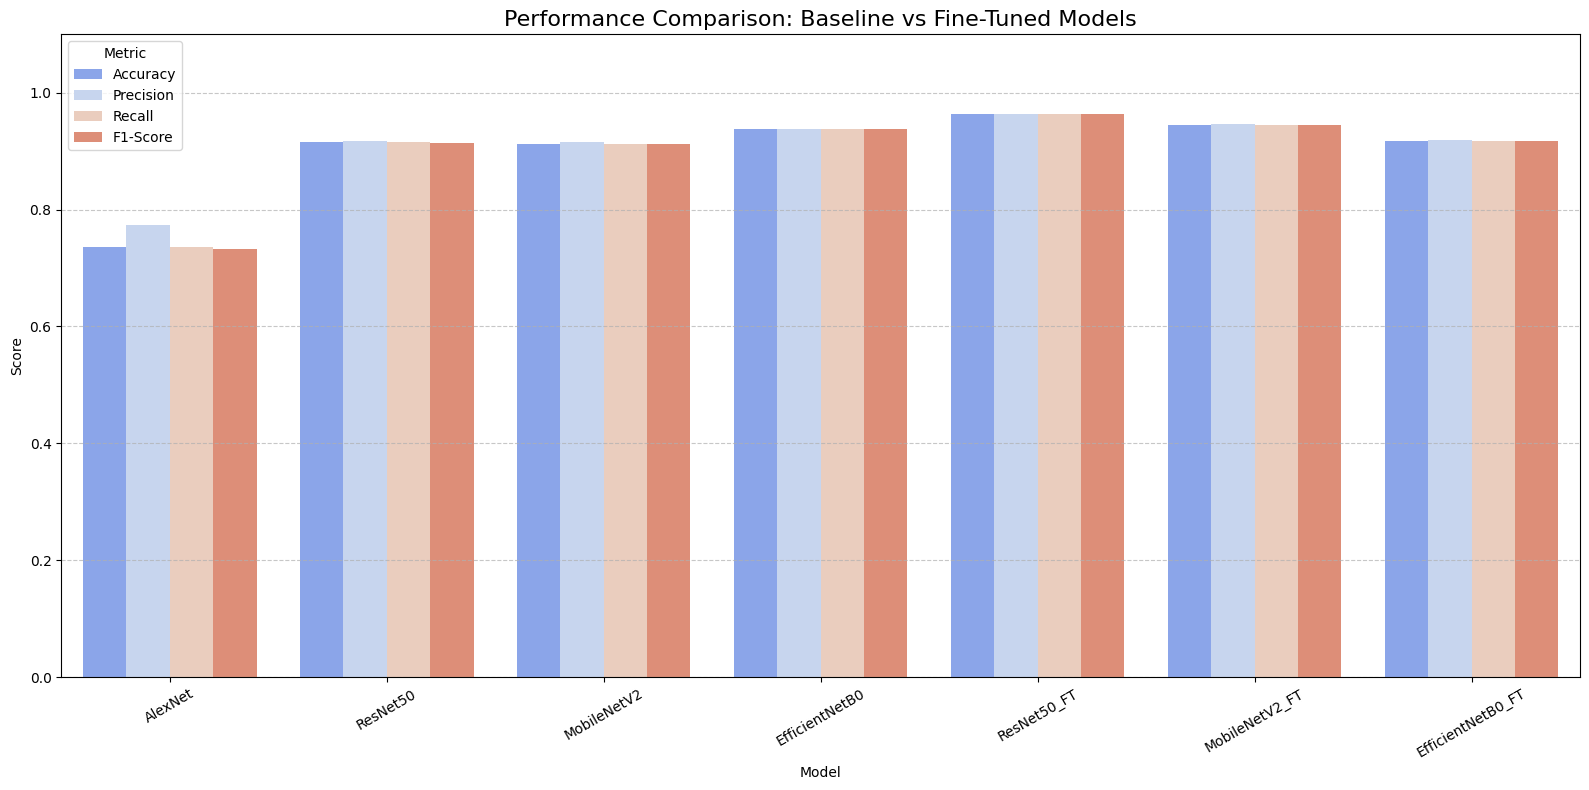

✅ Saved Final Comparison Chart: /content/drive/MyDrive/FYP/MyModels/graphs/final_comparison_chart.png

--- 💾 Dashboard Data Saved: /content/drive/MyDrive/FYP/MyModels/model_metrics.json ---

--- 📋 COPY THIS INTO YOUR app.py ---
MODEL_METRICS = {
    "AlexNet": {
        "accuracy": 73.62,
        "precision": 77.39,
        "recall": 73.62,
        "f1_score": 73.32,
        "loss": 0.7476
    },
    "ResNet50": {
        "accuracy": 91.57,
        "precision": 91.81,
        "recall": 91.57,
        "f1_score": 91.47,
        "loss": 0.2366
    },
    "MobileNetV2": {
        "accuracy": 91.3,
        "precision": 91.51,
        "recall": 91.3,
        "f1_score": 91.27,
        "loss": 0.2442
    },
    "EfficientNetB0": {
        "accuracy": 93.78,
        "precision": 93.81,
        "recall": 93.78,
        "f1_score": 93.78,
        "loss": 0.1606
    },
    "ResNet50_FT": {
        "accuracy": 96.41,
        "precision": 96.45,
        "recall": 96.41,
        "f1_score": 96.41,


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
import json

# Import all preprocessing functions
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

print("--- 📊 Starting Final Evaluation for Dashboard ---")

# --- 1. Mount Drive and Set Paths ---
drive.mount('/content/drive', force_remount=True)
BASE_DIR = '/content/drive/MyDrive/FYP'
TEST_DIR = os.path.join(BASE_DIR, 'test')
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'MyModels')
GRAPH_DIR = os.path.join(MODEL_SAVE_DIR, 'graphs')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

os.makedirs(GRAPH_DIR, exist_ok=True)
print(f"Graphs will be saved to: {GRAPH_DIR}")

# --- 2. Get Class Names and True Labels ---
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Test directory not found: {TEST_DIR}")

class_names = sorted([d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))])
NUM_CLASSES = len(class_names)

print(f"Loading final test data from: {TEST_DIR}")
test_gen_for_labels = ImageDataGenerator(rescale=1./255).flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)
true_labels = test_gen_for_labels.classes
print(f"Loaded {len(true_labels)} labels from the test set.")

# --- 3. Define ALL Models for Evaluation ---
# This includes both baseline (.h5) and Fine-Tuned (.keras) models
model_eval_config = {
    'AlexNet': {
        'path': os.path.join(MODEL_SAVE_DIR, 'AlexNet_v1.h5'),
        'generator': ImageDataGenerator(rescale=1./255)
    },
    'ResNet50': {
        'path': os.path.join(MODEL_SAVE_DIR, 'ResNet50_v1.h5'),
        'generator': ImageDataGenerator(preprocessing_function=resnet_preprocess)
    },
    'MobileNetV2': {
        'path': os.path.join(MODEL_SAVE_DIR, 'MobileNetV2_v1.h5'),
        'generator': ImageDataGenerator(preprocessing_function=mobilenet_preprocess)
    },
    'EfficientNetB0': {
        'path': os.path.join(MODEL_SAVE_DIR, 'EfficientNetB0_v1.h5'),
        'generator': ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
    },
    'ResNet50_FT': {
        'path': os.path.join(MODEL_SAVE_DIR, 'ResNet50_v1_ft.keras'),
        'generator': ImageDataGenerator(preprocessing_function=resnet_preprocess)
    },
    'MobileNetV2_FT': {
        'path': os.path.join(MODEL_SAVE_DIR, 'MobileNetV2_v1_ft.keras'),
        'generator': ImageDataGenerator(preprocessing_function=mobilenet_preprocess)
    },
    'EfficientNetB0_FT': {
        'path': os.path.join(MODEL_SAVE_DIR, 'EfficientNetB0_v1_ft.keras'),
        'generator': ImageDataGenerator(preprocessing_function=efficientnet_preprocess)
    }
}

model_performance_report = {}
dashboard_data = {}

# --- 4. Loop, Load, Predict, and Evaluate ---
for model_name, config in model_eval_config.items():
    print(f"\n--- 🔄 Evaluating: {model_name} ---")

    if not os.path.exists(config['path']):
        print(f"⚠️ Model file not found: {config['path']}. Skipping.")
        continue

    try:
        # Load model without compiling for speed; re-compile for metric evaluation
        model = load_model(config['path'], compile=False)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")
        continue

    test_generator = config['generator'].flow_from_directory(
        TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )

    print("   Calculating Metrics...")
    eval_results = model.evaluate(test_generator, verbose=0)

    predictions = model.predict(test_generator, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
    model_performance_report[model_name] = report

    # Store for Dashboard/JSON
    dashboard_data[model_name] = {
        "accuracy": round(report['accuracy'] * 100, 2),
        "precision": round(report['weighted avg']['precision'] * 100, 2),
        "recall": round(report['weighted avg']['recall'] * 100, 2),
        "f1_score": round(report['weighted avg']['f1-score'] * 100, 2),
        "loss": round(eval_results[0], 4)
    }

    # Generate Confusion Matrix Plot
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix: {model_name}')

    cm_path = os.path.join(GRAPH_DIR, f'cm_{model_name}.png')
    plt.savefig(cm_path)
    plt.close()
    print(f"   ✅ Saved Confusion Matrix: {cm_path}")

# --- 5. Generate Final Comparison Bar Chart ---
if model_performance_report:
    print("\n--- 📊 Generating Final Comparison Chart ---")
    data_list = []
    for name, rep in model_performance_report.items():
        data_list.append({
            'Model': name,
            'Accuracy': rep['accuracy'],
            'Precision': rep['weighted avg']['precision'],
            'Recall': rep['weighted avg']['recall'],
            'F1-Score': rep['weighted avg']['f1-score']
        })

    df = pd.DataFrame(data_list)
    df_melted = df.melt('Model', var_name='Metric', value_name='Score')

    plt.figure(figsize=(16, 8))
    sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', palette="coolwarm")
    plt.title('Performance Comparison: Baseline vs Fine-Tuned Models', fontsize=16)
    plt.ylim(0, 1.1)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    comparison_path = os.path.join(GRAPH_DIR, 'final_comparison_chart.png')
    plt.savefig(comparison_path)
    plt.show()
    print(f"✅ Saved Final Comparison Chart: {comparison_path}")

# --- 6. Save Dashboard Data to JSON ---
json_path = os.path.join(MODEL_SAVE_DIR, 'model_metrics.json')
with open(json_path, 'w') as f:
    json.dump(dashboard_data, f, indent=4)
print(f"\n--- 💾 Dashboard Data Saved: {json_path} ---")

# --- 7. Print Output for app.py ---
print("\n" + "="*70)
print("--- 📋 COPY THIS INTO YOUR app.py ---")
print("="*70)
print("MODEL_METRICS = " + json.dumps(dashboard_data, indent=4))
print("="*70)